In [2]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

california_housing_df = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_df = california_housing_df.reindex(
    np.random.permutation(california_housing_df.index))
california_housing_df['median_house_value'] /= 1000.0
california_housing_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10469,-120.37,34.69,18.0,1868.0,315.0,747.0,265.0,4.7946,290.600
14940,-122.23,37.76,52.0,1316.0,177.0,378.0,162.0,5.2915,333.000
16349,-122.52,38.53,35.0,1227.0,236.0,548.0,207.0,4.8750,336.700
15526,-122.33,38.29,14.0,3541.0,499.0,1577.0,459.0,5.3351,269.900
9432,-119.24,34.28,41.0,1280.0,240.0,608.0,252.0,4.4038,229.100
9820,-119.69,35.62,18.0,820.0,239.0,1345.0,207.0,2.1186,47.500
7025,-118.31,33.80,31.0,4464.0,991.0,2420.0,947.0,4.0425,277.900
9972,-119.76,36.74,52.0,2137.0,448.0,1194.0,444.0,1.3029,69.100
9597,-119.38,36.55,31.0,2342.0,439.0,1411.0,465.0,3.0170,72.000
14684,-122.18,37.75,45.0,990.0,261.0,901.0,260.0,2.1731,82.000


In [3]:
def my_input_function(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [6]:
def train_model(learning_rate, steps, batch_size, input_feature):
    periods = 10
    steps_per_periods = steps/periods
    
    my_feature = input_feature
    my_feature_data = california_housing_df[[my_feature]].astype('float32')
    my_label = 'median_house_value'
    targets = california_housing_df[my_label].astype('float32')
    
    #Create training and prediction function
    training_input_function = lambda: my_input_function(my_feature_data, targets, batch_size=batch_size)
    predict_input_function = lambda: my_input_function(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    #Create feature columns
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    #Create linear regressor
    my_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=my_optimizer)
    
    #Setup to plot the state of our model line each period
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title('Learned Line by Period')
    plt.xlabel(my_feature)
    plt.ylabel(my_label)
    plt.scatter(california_housing_df[my_feature], california_housing_df[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1,1,periods)]
    
    
    #Train the model and calcualte the loss metrics for each period
    print('Training model...')
    print('RMSE on training data: ')
    root_mean_squared_errors = []
    for period in range(0, periods):
        linear_regressor.train(input_fn= training_input_function, steps=steps_per_periods)
        
        #Compute predictions
        predictions = linear_regressor.predict(input_fn=predict_input_function)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        #Compute loss
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions, targets))
        print(' period %02d: %0.2f' % (period, root_mean_squared_error))
        root_mean_squared_errors.append(root_mean_squared_error)
        
        #Track the weights and biases over time
        y_extents = np.array([0, california_housing_df[my_label].max()])
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents, california_housing_df[my_feature].max()), california_housing_df[my_feature].min())
        
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period])
    print('Model training finished!!!')
    
    #Ouput the graph of loss metrics over periods
    plt.subplot(1,2,2)
    plt.xlabel('Periods')
    plt.ylabel('RSME')
    plt.title('Root Mean Squared Error vs Periods')
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    plt.show()
    
    #Create a table with calibration data
    calibration_data = pd.DataFrame()
    calibration_data['predictions'] = pd.Series(predictions)
    calibration_data['targets'] = pd.Series(targets)
    display.display(calibration_data.describe())
    
    print('Final RMSE: %0.2f' % root_mean_squared_error)
    return calibration_data
        
    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_log_step_count_steps': 100, '_save_summary_steps': 100, '_session_config': None, '_is_chief': True, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000213E5C441D0>, '_master': '', '_model_dir': 'C:\\Users\\STRIKE~1\\AppData\\Local\\Temp\\tmpb87eavae', '_keep_checkpoint_max': 5, '_service': None, '_num_worker_replicas': 1, '_save_checkpoints_steps': None, '_tf_random_seed': None, '_task_type': 'worker'}
Training model...
RMSE on training data: 
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\STRIKE~1\AppData\Local\Temp\tmpb87eavae\model.ckpt.
INFO:tensorflow:loss = 170491.52, step = 1
INFO:tensorflow:Saving checkpoints for 50 into C:\Users\STRIKE~1\AppData\Local\Temp\tmpb87eavae\model.ckpt.
INFO:tensorflow:Loss for final step

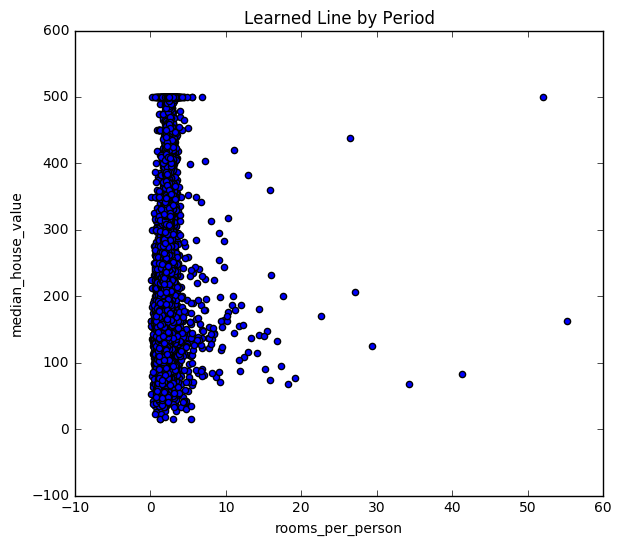

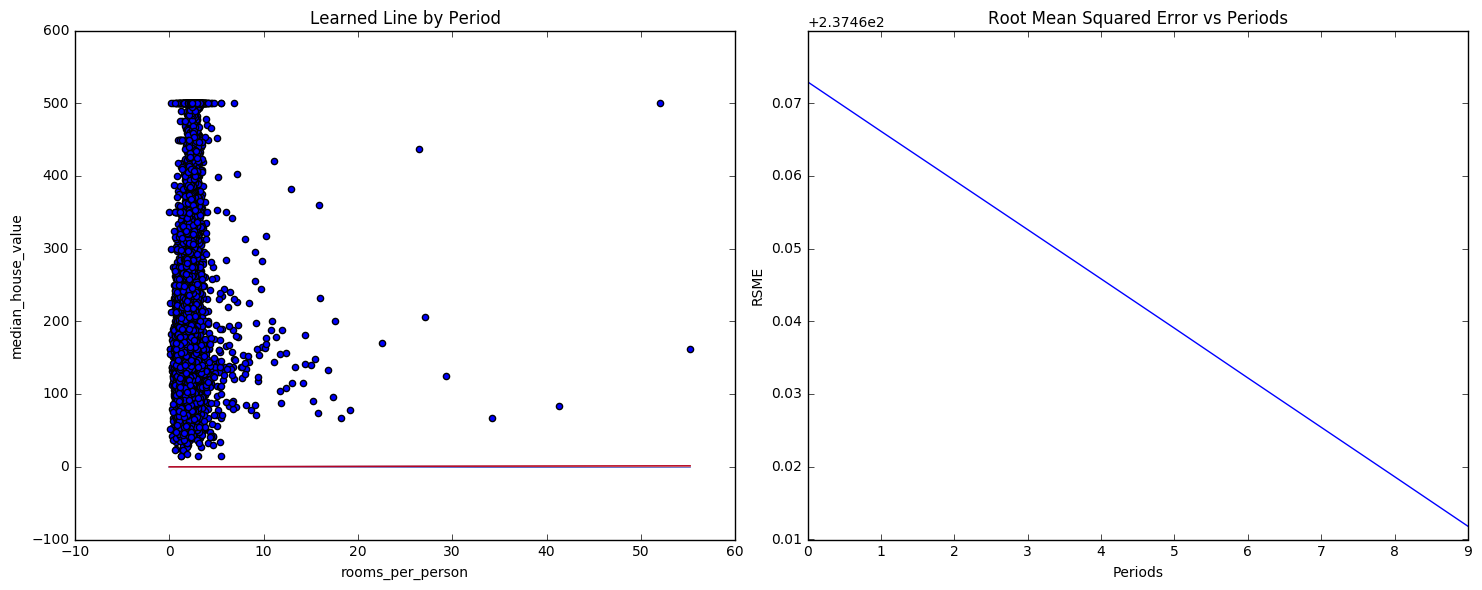

,predictions,targets
count,17000.000000,17000.000000
mean,0.074418,207.299591
std,0.029112,115.984344
min,0.025542,14.999000
25%,0.062989,119.400002
50%,0.073429,180.399994
75%,0.082307,265.000000
max,1.400113,500.001007


Final RMSE: 237.47


In [7]:
california_housing_df['rooms_per_person'] = california_housing_df['total_rooms'] / california_housing_df['population']

calibration_data = train_model(learning_rate=0.00005, steps=500, batch_size=5, input_feature='rooms_per_person')

Identify Outliers

In [9]:
calibration_data

,predictions,targets
0,0.087359,66.900002
1,0.111781,80.099998
2,0.080844,85.699997
3,0.081003,73.400002
4,0.077513,65.500000
5,0.040273,74.000000
6,0.071023,82.400002
7,0.069658,48.500000
8,0.066422,58.400002
9,0.052452,48.099998


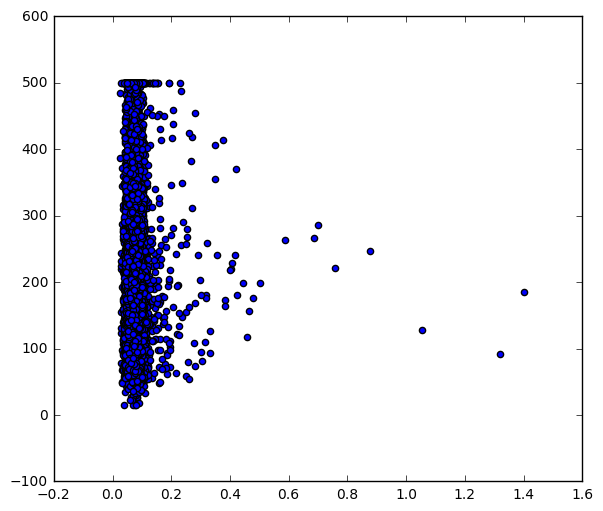

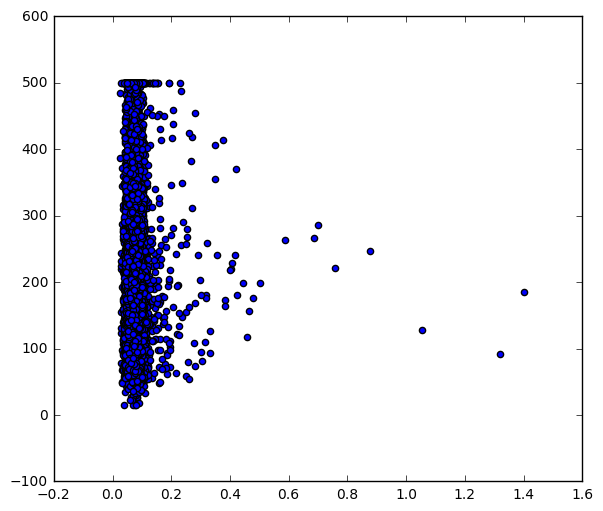

In [11]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(calibration_data['predictions'], calibration_data['targets'])
plt.show()

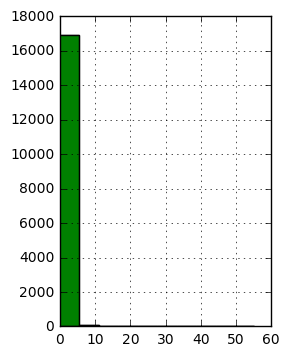

In [14]:
plt.subplot(1,2,2)
_ = california_housing_df['rooms_per_person'].hist()
plt.show()

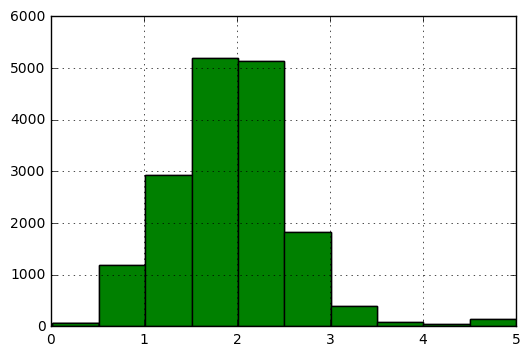

In [17]:
#CLIP outliers
california_housing_df['rooms_per_person'] = california_housing_df['rooms_per_person'].apply(lambda x: min(x,5))

_ = california_housing_df['rooms_per_person'].hist()
plt.show()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_log_step_count_steps': 100, '_save_summary_steps': 100, '_session_config': None, '_is_chief': True, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002160F2B0AC8>, '_master': '', '_model_dir': 'C:\\Users\\STRIKE~1\\AppData\\Local\\Temp\\tmp9gqxiebr', '_keep_checkpoint_max': 5, '_service': None, '_num_worker_replicas': 1, '_save_checkpoints_steps': None, '_tf_random_seed': None, '_task_type': 'worker'}
Training model...
RMSE on training data: 
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\STRIKE~1\AppData\Local\Temp\tmp9gqxiebr\model.ckpt.
INFO:tensorflow:loss = 300852.2, step = 1
INFO:tensorflow:Saving checkpoints for 50 into C:\Users\STRIKE~1\AppData\Local\Temp\tmp9gqxiebr\model.ckpt.
INFO:tensorflow:Loss for final step:

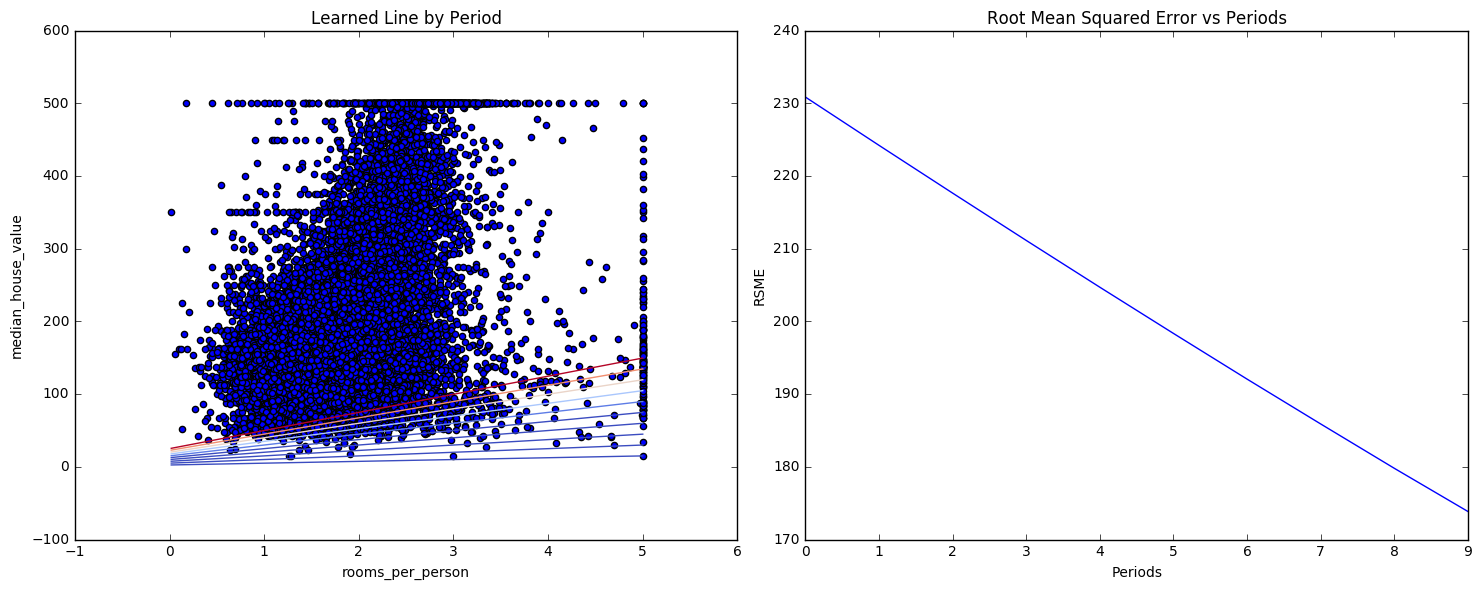

,predictions,targets
count,17000.000000,17000.000000
mean,73.354393,207.299591
std,16.339828,115.984344
min,25.439003,14.999000
25%,62.918900,119.400002
50%,73.368210,180.399994
75%,82.253979,265.000000
max,149.597488,500.001007


Final RMSE: 173.85


In [18]:
calibration_data = train_model(learning_rate=0.05, steps=500, batch_size=5, input_feature='rooms_per_person')

       predictions     targets
0        87.309822   66.900002
1       111.753372   80.099998
2        80.789841   85.699997
3        80.948135   73.400002
4        77.455620   65.500000
5        40.182716   74.000000
6        70.960136   82.400002
7        69.593285   48.500000
8        66.354294   58.400002
9        52.372280   48.099998
10       93.464615   86.500000
11       82.031517   62.000000
12       82.507652   48.599998
13       76.774895   70.400002
14       98.009903   45.000000
15       48.915810   69.099998
16       75.123566   94.900002
17       83.846519   25.000000
18       98.523308   44.000000
19       61.569984   27.500000
20       55.998428   44.400002
21       78.792618   59.200001
22       76.161827   50.000000
23       92.140015   71.300003
24       83.525902   53.500000
25       83.041786  100.000000
26       69.724297   71.099998
27       75.957504   80.900002
28       96.818512   68.599998
29       77.293938   74.300003
...            ...         ...
16970   

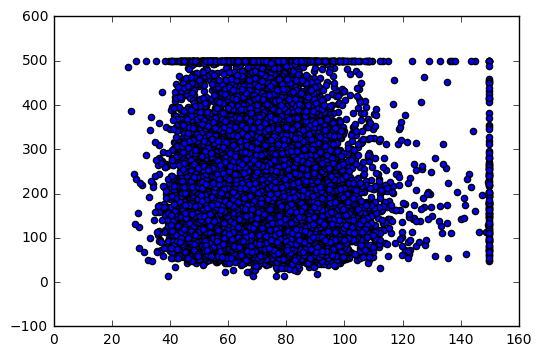

In [23]:
print(calibration_data)
_ = plt.scatter(calibration_data['predictions'], calibration_data['targets'])
plt.show()